# Tsui et al. haematopoiesis

## Reference:    
[Tusi B. K. et al. Population snapshots predict early haematopoietic and erythroid hierarchies. Nature volume 555, pages 54–60 (01 March 2018)](https://www.nature.com/articles/nature25741#abstract)
## GEO:    
[GSE89754](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE89754)

In [1]:
%pylab inline

import warnings
warnings.filterwarnings("ignore")
from SCCAF import *

Populating the interactive namespace from numpy and matplotlib


Mice for scRNA-seq
For the basal bone marrow (bBM) sample, and for the sorted P1–P5 populations, bone marrow was collected from 8-week-old adult BALB/cJ female mice (Jackson Laboratories). For the EPO-stimulated bone marrow (eBM) sample, 8-week-old adult BALB/cJ female mice were injected with EPO (Procrit, Amgen) subcutaneously once every 24 h for a total of 48 h, at 100 U per 25 g body weight. For the fetal liver (FL) sample, BALB/cJ female mice were set up for timed pregnancies, and fetal livers were collected on embryonic day 13.5.

# Preprocessing

In [2]:
X = pd.read_csv("ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2388nnn/GSM2388072/suppl/GSM2388072_basal_bone_marrow.raw_umifm_counts.csv.gz", index_col=0)
print(X.shape)
# remove this library to avoid dealing with batch effects
X.drop(X.index[X["library_id"] == "basal_bm1"], inplace=True)
print(X.shape)

(5432, 28209)
(4592, 28209)


In [3]:
X.head()

,barcode,library_id,seq_run_id,pass_filter,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
cell_id,,,,,,,,,,,,,,,,,,,,,
bBM841,AAGATGGCT-GGTGGGAT,basal_bm2,seq_run4,0,4,1,0,1,0,4,...,198,65,97,117,79,13,102,7,11,0
bBM842,ATTTCCGG-AGTGAAAG,basal_bm2,seq_run4,1,3,2,0,1,0,0,...,119,56,79,54,47,5,61,0,12,0
bBM843,AACTCACCG-AAACTGGT,basal_bm2,seq_run4,1,3,0,0,0,0,3,...,143,70,89,53,58,9,64,2,6,0
bBM844,TTCGGCCT-AGAACGGG,basal_bm2,seq_run4,1,2,1,0,0,0,1,...,167,81,59,74,77,4,60,0,17,0
bBM845,TGAACGCTCAG-TCACGTTT,basal_bm2,seq_run4,0,0,0,0,0,0,0,...,28,6,5,5,1,0,0,0,1,0


In [4]:
X = X[X.pass_filter==1]
cts = X.iloc[:,4:].T

get the `spring` plot result and the differentiation potential.

In [5]:
Y = pd.read_csv("https://github.com/chichaumiau/removeBatcheffect/raw/master/data/HEMATO/bBM.spring_and_pba.csv", index_col=0)
Y = Y.loc[X.index]

In [6]:
Y.head()

,x_spring,y_spring,Potential,Pr_Er,Pr_Gr,Pr_Ly,Pr_DC,Pr_Mk,Pr_Mo,Pr_Ba
cell_id,,,,,,,,,,
bBM842,297.49,-499.25,16.478,4.838100e-07,0.99999,6.165000e-07,0.000006,7.316800e-08,0.000003,2.895200e-07
bBM843,216.79,-244.52,20.014,7.798200e-04,0.97960,1.192900e-03,0.012171,1.097700e-04,0.005926,2.229200e-04
bBM844,221.31,-287.19,19.501,3.258200e-04,0.99471,5.407800e-04,0.002864,3.707600e-05,0.001452,7.155600e-05
bBM846,181.05,-200.11,20.514,4.636700e-03,0.95515,4.485400e-03,0.019768,4.857800e-04,0.014610,8.653300e-04
bBM847,247.21,-371.40,18.693,5.134800e-05,0.99885,1.868000e-04,0.000635,6.945500e-06,0.000255,1.507100e-05


In [7]:
obs = pd.concat([X.iloc[:,:4],Y], axis=1)

In [8]:
ad = sc.AnnData(scipy.sparse.csr_matrix(cts.values.T))
ad.obs_names = cts.columns
ad.var_names = cts.index
ad = ad[ad.obs_names.isin(obs.index),:]
ad.obs = obs.loc[ad.obs_names]

In [3]:
ad.raw = sc.pp.log1p(ad, copy=True)

In [4]:
ad.write("../write/HEMATO_Tsui2018.h5")

In [2]:
ad = sc.read("../write/HEMATO_Tsui2018.h5")

In [10]:
sc.pp.normalize_per_cell(ad, counts_per_cell_after=1e4)
ad.raw = sc.pp.log1p(ad, copy=True)

use the gene list used in the paper

In [11]:
gene_filter_list = np.loadtxt("https://github.com/chichaumiau/removeBatcheffect/raw/master/data/HEMATO/bBM.filtered_gene_list.paper.txt", dtype=np.str)

In [12]:
ad.shape

(4016, 28205)

In [13]:
ad = ad[:, ad.var_names.isin(gene_filter_list)]

In [14]:
ad.shape

(4016, 7397)

In [15]:
ad.obsm['X_spring'] = obs.iloc[:,4:6].values

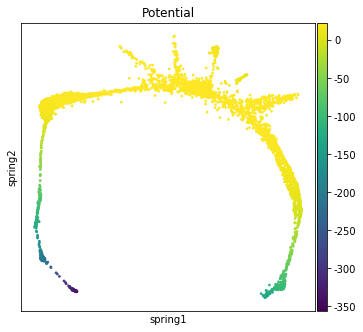

In [16]:
figsize(5,5)
sc.pl.scatter(ad, basis='spring',color='Potential')

In [17]:
n_pcs = 50
sc.pp.log1p(ad)
# sc.pp.scale(ad, max_value=10)
sc.tl.pca(ad)
sc.tl.tsne(ad, n_pcs=n_pcs, random_state=2)
sc.pp.neighbors(ad, n_neighbors=10, n_pcs=n_pcs)
sc.tl.umap(ad)
sc.tl.louvain(ad, resolution=1.0)

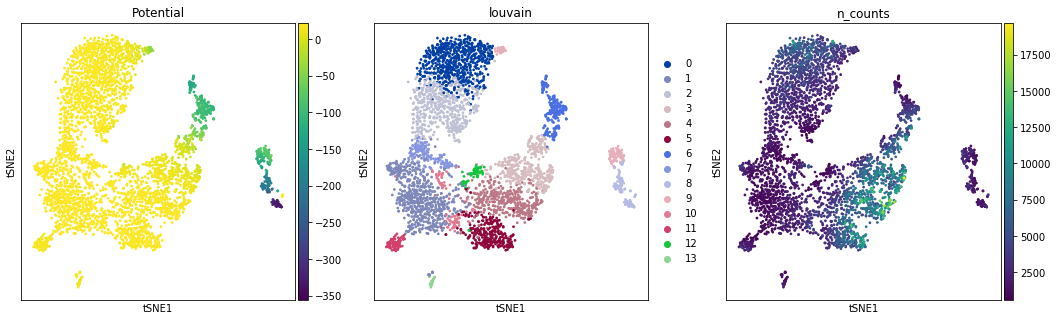

In [18]:
sc.pl.tsne(ad,color=['Potential','louvain','n_counts'])

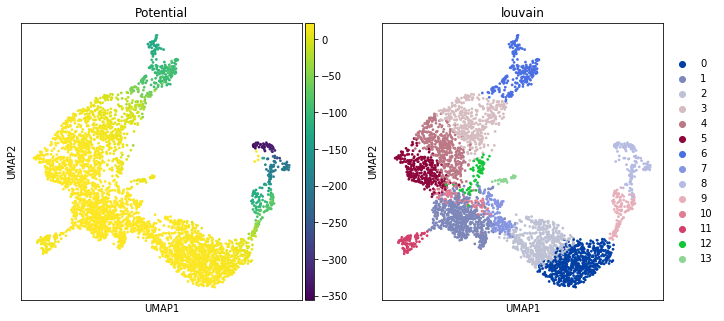

In [19]:
sc.pl.umap(ad,color=['Potential','louvain'])

In [20]:
ad.write("../write/HEMATO_Tsui2018_reg.h5")

In [21]:
ls -lh ../write/HEMATO*

-rw-r--r--  1 zmiao  384566875   159M 23 Apr 16:32 ../write/HEMATO_0Er.h5
-rw-r--r--  1 zmiao  384566875   187M 23 Apr 16:35 ../write/HEMATO_0Er_reg.h5
-rw-r--r--  1 zmiao  384566875   5.6M  2 Jan  2019 ../write/HEMATO_0Gr.h5
-rw-r--r--  1 zmiao  384566875    13M  2 Jan  2019 ../write/HEMATO_0Gr_reg.h5
-rw-r--r--  1 zmiao  384566875    52M  8 Oct 15:22 ../write/HEMATO_Tsui2018.h5
-rw-r--r--  1 zmiao  384566875    87M  8 Oct 15:23 ../write/HEMATO_Tsui2018_reg.h5


# End